In [16]:
# convert coco to aimmo
import os
import json
import numpy as np
from tqdm import tqdm
import shutil

import cv2
import numpy as np
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon

parent_path = "/data/noah/dataset/coco_rider/pre_images"
out_annotation_path = "/data/noah/dataset/coco_rider/anno"
out_images_path = "/data/noah/dataset/coco_rider/images"

caption_path = "/data/noah/dataset/coco_rider/src_anno/captions_train2017.json"

with open(caption_path, "r") as f:
    caption_annotation = json.load(f)

image_ids = []
image_names = []

for ann in caption_annotation["annotations"]:
    if "rider" in ann["caption"]:
        image_ids.append(ann["image_id"])

image_ids = list(set(image_ids))

for image_info in caption_annotation["images"]:
    if image_info["id"] in image_ids:
        image_names.append(image_info["file_name"])


instance_path = "/data/noah/dataset/coco_rider/src_anno/instances_train2017.json"

with open(instance_path, "r") as f:
    instance_annotation = json.load(f)

target_class = {"person": None, "motorcycle": None, "bicycle": None}

for target in target_class:
    for cat in instance_annotation["categories"]:
        if cat["name"] == target:
            target_class[target] = cat["id"]

for image_info in tqdm(instance_annotation["images"]):
    if image_info["file_name"] not in image_names:
        continue

    image_name = image_info["file_name"]
    height, width = image_info["height"], image_info["width"]
    image_id = image_info["id"]

    aimmo_format = {
        "annotations": [],
        "attributes": {},
        "filename": image_name,
        "parent_path": out_images_path,
        "metadata": {"height": height, "width": width},
    }

    annotations = []
    check_list = {key: False for key in target_class}

    for idx, ann in enumerate(instance_annotation["annotations"]):
        if ann["image_id"] == image_id and ann["category_id"] in list(target_class.values()):
            points = ann["segmentation"]

            if isinstance(points, dict):
                continue
            else:
                combined_polygon = []
                for point in points:
                    polygon_points = np.array(point).reshape(-1, 2).astype(np.int32).tolist()
                    combined_polygon.append(polygon_points)

                # for point in points:
                #     polygon_points = np.array(point).reshape(-1, 2).astype(np.int32).tolist()

                label = [key for key, value in target_class.items() if value == ann["category_id"]]
                check_list[label[0]] = True
                a = {
                    "id": "",
                    "type": "poly_seg",
                    "attributes": {},
                    "points": combined_polygon,
                    "label": label[0],
                }
                annotations.append(a)

    check_list = list(check_list.values())
    if len(annotations) and check_list[0] and any(check_list[1:]):
        aimmo_format["annotations"] = annotations
        path = os.path.join(out_annotation_path, "{}.json".format(image_name))
        with open(path, "w") as f:
            json.dump(aimmo_format, f)

        src_image_path = os.path.join(parent_path, image_name)
        dst_image_path = os.path.join(out_images_path, image_name)
        shutil.copy(src_image_path, dst_image_path)

100%|██████████| 118287/118287 [03:19<00:00, 593.45it/s] 


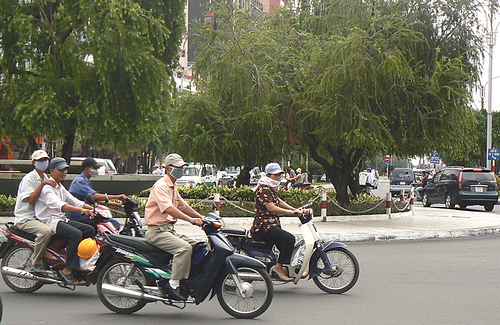

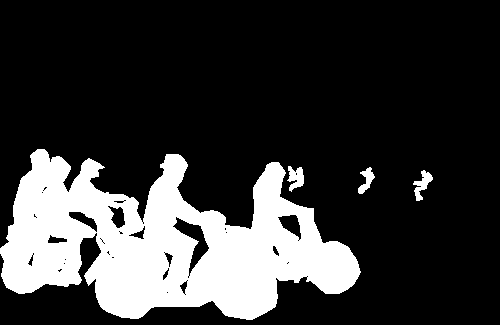

In [20]:
from PIL import Image
import numpy as np
import cv2
import json

image_path = "/data/noah/dataset/coco_rider/images/000000016346.jpg"
anno_path = "/data/noah/dataset/coco_rider/anno/000000016346.jpg.json"

image = Image.open(image_path)

with open(anno_path, "r") as f:
    annotation = json.load(f)

height, width = image.height, image.width
mask = np.zeros((height, width))

for ann in annotation["annotations"]:
    for point in ann["points"]:
        point = np.array(point, dtype=np.int32)
        try:
            mask = cv2.fillPoly(mask, [point], color=255)
        except:
            continue

display(image)
display(Image.fromarray(mask).convert("L"))

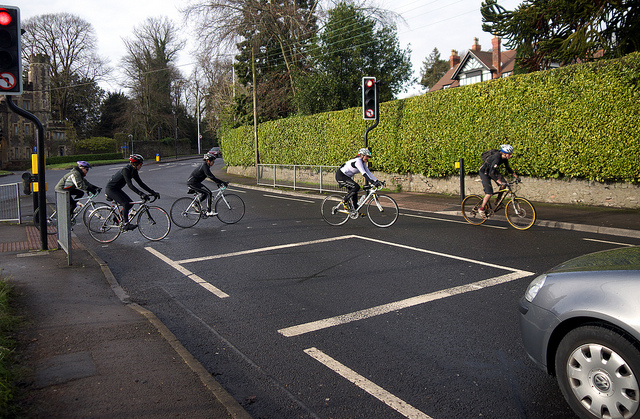

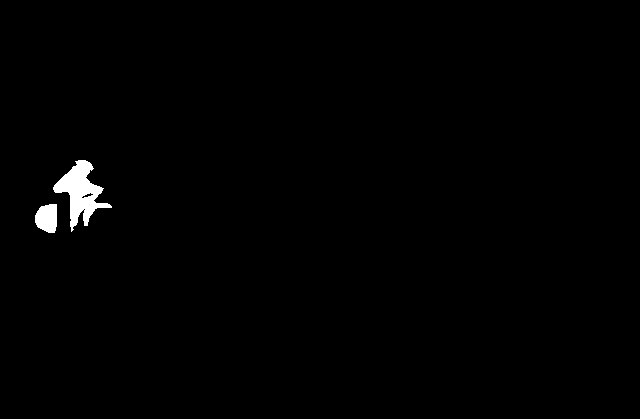

In [78]:
from PIL import Image
import numpy as np
import cv2
import json
import random
from shapely.geometry import Polygon


def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)


image_path = "/data/noah/dataset/coco_rider/images/000000001053.jpg"
anno_path = "/data/noah/dataset/coco_rider/anno/000000001053.jpg.json"

image = Image.open(image_path)

with open(anno_path, "r") as f:
    annotation = json.load(f)

person_idxs = []
vehicle_idxs = []
for idx, ann in enumerate(annotation["annotations"]):
    if ann["label"] == "person":
        person_idxs.append(idx)
    else:
        vehicle_idxs.append(idx)

select_idx = None
while select_idx is None:
    target_idx = random.choice(person_idxs)
    target_ann = annotation["annotations"][target_idx]
    # target_poly = Polygon(target_ann["points"]).centroid
    total_mean_distance = 10000000
    total_min_distance = None

    for idx in vehicle_idxs:
        ann = annotation["annotations"][idx]
        distances = []

        for t_points in target_ann["points"]:
            for t_point in t_points:
                min_distance = 10000000
                for points in ann["points"]:
                    for point in points:
                        distance = euclidean_distance(t_point, point)
                        if distance < min_distance:
                            min_distance = distance
                distances.append(min_distance)

        mean_distance = np.mean(distances)
        if mean_distance < total_mean_distance:
            total_mean_distance = mean_distance
            total_min_distance = np.min(distances)
            select_idx = idx

    if total_min_distance > 5:
        select_idx = None

height, width = image.height, image.width
mask = np.zeros((height, width))

# person_point = np.array(annotation["annotations"][target_idx]["points"], dtype=np.int32)
# vehicle_point = np.array(annotation["annotations"][select_idx]["points"], dtype=np.int32)

try:
    for person_points in annotation["annotations"][target_idx]["points"]:
        person_point = np.array(person_points, dtype=np.int32)
        mask = cv2.fillPoly(mask, [person_point], color=255)

    for vehicle_points in annotation["annotations"][select_idx]["points"]:
        vehicle_point = np.array(vehicle_points, dtype=np.int32)
        mask = cv2.fillPoly(mask, [vehicle_point], color=255)
except Exception as e:
    print(e)

display(image)
display(Image.fromarray(mask).convert("L"))

In [80]:
# Format {"image": "", "conditioning_images": "", "text": "", "annotation": ""}

# annotation -> mask -> condition image 생성
# prompt
import json
import os
import cv2
from PIL import Image
import numpy as np
import random

import cv2
import os
import csv
import json
import shutil
import numpy as np
from tqdm import tqdm
import torch
from PIL import Image
from controlnet_aux.processor import Processor
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from controlnet_aux.processor import MidasDetector


anno_path = "/data/noah/dataset/coco_rider/anno"
condition_path = "/data/noah/dataset/coco_rider/conditioning_images"
midas = MidasDetector.from_pretrained("lllyasviel/Annotators").to("cuda:3")

for anno_name in tqdm(os.listdir(anno_path)[:]):
    ann_path = os.path.join(anno_path, anno_name)
    with open(ann_path, "r") as f:
        ann = json.load(f)

    # con_path
    image_path = os.path.join(ann["parent_path"], ann["filename"])
    image = Image.open(image_path).convert("RGB")
    con_path = os.path.join(condition_path, ann["filename"])
    con_image = midas(image)
    con_image.save(con_path)

100%|██████████| 388/388 [00:37<00:00, 10.39it/s]


In [82]:
import json
import os
import cv2
from PIL import Image
import numpy as np
import random

import cv2
import os
import csv
import json
import shutil
import numpy as np
from tqdm import tqdm
import torch
from PIL import Image
from controlnet_aux.processor import Processor
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

annotation_path = "/data/noah/dataset/coco_rider/anno"
caption_path = "/data/noah/dataset/coco_rider/train.jsonl"
gt_caption_path = "/data/noah/dataset/coco_rider/src_anno/captions_train2017.json"

data = []

with open(gt_caption_path, "r") as f:
    gt_ann = json.load(f)

for annotation_name in tqdm(os.listdir(annotation_path)):
    anno_path = os.path.join(annotation_path, annotation_name)
    with open(anno_path, "r") as f:
        annotation = json.load(f)

    for img_info in gt_ann["images"]:
        if img_info["file_name"] == annotation["filename"]:
            image_id = img_info["id"]
            break

    captions = []
    for cap_info in gt_ann["annotations"]:
        if cap_info["image_id"] == image_id:
            captions.append(cap_info["caption"])

    caption = random.choice(captions)

    data.append(
        {
            "text": caption,
            "image": "images/{}".format(annotation["filename"]),
            "conditioning_images": "conditioning_images/{}".format(annotation["filename"]),
            "annotation": "anno/{}".format(annotation_name),
        }
    )

with open(caption_path, encoding="utf-8", mode="w") as f:
    for i in data:
        f.write(json.dumps(i) + "\n")

100%|██████████| 388/388 [00:29<00:00, 13.30it/s]
